# Introduction
This is a series that I am very excited about. We are going to explore some unsupervised models, the main idea is to understand the X-space or the space of the feautures.

All the other things we saw so far explore how feautures helps us make certain kind of predictions. And then we look deeper at the model itself and try to explain how those feauture impact the model (shap and permutation analysis).

But we haven't stopped to analysis with greater care how all the feautures that make those predictions move together. That what we are going to explore here. Graph theory was the only exception, because with graph theory we understand the underlying pattern of connections.

We already saw PCA and SVD. Now we are going to do something more subtle to the categorical variables, hopefully increasing their predicting power.

In this notebook we are going to explore Target encoder.
you can read more here: 
https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.TargetEncoder.html

In [1]:
import plotly.io as pio
pio.renderers.default = "svg"
import os
os.environ['OMP_NUM_THREADS'] = "6"
print(os.environ['OMP_NUM_THREADS'])

6


In [2]:
# import libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
# new library, we haven't used this one before in this repo
from sklearn.preprocessing import TargetEncoder

In [3]:
# Read the data
# This data you can find here: https://www.kaggle.com/c/home-data-for-ml-course/data

X_full = pd.read_csv('train.csv', index_col='Id')

# SalePrice is the target, if there is no target eliminate row associated with it
X_full.dropna(axis=0, subset=['SalePrice'], inplace=True)
y = X_full.SalePrice
X = X_full.copy()
X.drop(['SalePrice'], axis=1, inplace=True)

In [4]:
def model_pipeline_score(X,
                         y,
                         n_estimators=369,
                         cv=5,
                         scoring='neg_mean_absolute_error',
                         target_encoding='yes'):

    
    numerical_col = [col for col in X.columns if str(X[col].dtypes)!='object' ]
    numerical_col_imputed = [col for col in numerical_col if X[col].isnull().any()==True]

    categorical_col = [col for col in X.columns if str(X[col].dtypes)=='object' ]
    categorical_col_imputed = [col for col in categorical_col if X[col].isnull().any()==True]

    numerical_transformer = Pipeline(
    steps=[("scaler", StandardScaler()), ("imputer", KNNImputer(n_neighbors=3))
      ]
        )

    if target_encoding =="no":
        categorical_transformer =  Pipeline(steps=[
            ('imputer', SimpleImputer(missing_values=pd.NA, strategy='most_frequent')),
            ('onehot', OneHotEncoder(handle_unknown='ignore'))
        ])
    elif target_encoding =="yes":
        categorical_transformer =  Pipeline(steps=[
            ('encoder', TargetEncoder(smooth="auto",target_type='continuous'))
        ])
        

    preprocessor = ColumnTransformer(transformers=
        [("numerical_transformer", numerical_transformer, numerical_col_imputed),
        ("categorical_transformer", categorical_transformer, categorical_col)],remainder='passthrough')

    # Define model
    model = RandomForestRegressor(n_estimators=n_estimators,random_state=0,n_jobs=-1)

    # Bundle preprocessing and modeling code in a pipeline
    pipe = Pipeline(steps=[('preprocessor', preprocessor),
                          ('model', model)
                         ])

    
    scores = -1 * cross_val_score(pipe, X, y,cv=cv,scoring=scoring)

    return scores,pipe

In [5]:
scores,pipe = model_pipeline_score(X,y,target_encoding='yes')

In [6]:
scores.mean()

17257.85705720756

In [7]:
#pipe

In [8]:
scores,pipe  = model_pipeline_score(X,y,target_encoding='no')

In [9]:
scores.mean()

17572.00848461224

In [10]:
#pipe

This was interesting! we use target encoder in all columns and it seems it work better than one-hot encoding. We are going to play a little with the max cardinality to lower the mae even more!. So what we are going to do next is to use target enconding in categorical columns who has a high cardinality and not in others.

In [11]:
def model_pipeline_score(X,
                         y,
                         n_estimators=369,
                         cv=5,
                         scoring='neg_mean_absolute_error',
                         cardinaity_target=13):

    
    numerical_col = [col for col in X.columns if str(X[col].dtypes)!='object' ]
    numerical_col_imputed = [col for col in numerical_col if X[col].isnull().any()==True]
    enc_target = [col for col in list(X.columns) if str(X[col].dtypes)=='object' and len(X[col].unique())>=cardinaity_target ]
   
    all_categories = [col for col in list(X.columns) if str(X[col].dtypes)=='object']
    col_encoding = [col for col in all_categories if col not in enc_target ]
    
   
    numerical_transformer = Pipeline(
    steps=[("scaler", StandardScaler()), 
           ("imputer", KNNImputer(n_neighbors=3))
          ])



    target_transformer =  Pipeline(steps=[
        ('encoder', TargetEncoder(smooth="auto",target_type='continuous'))
    ])
        
    categorical_transformer =  Pipeline(
        steps=[('imputer', SimpleImputer(missing_values=pd.NA, strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])    

    preprocessor = ColumnTransformer(transformers=
        [("numerical_transformer", numerical_transformer, numerical_col_imputed),
         ("target_transformer", target_transformer, enc_target),
        ("categorical_transformer", categorical_transformer, col_encoding)
        ], remainder='passthrough')

    # Define model
    model = RandomForestRegressor(n_estimators=n_estimators,random_state=0,n_jobs=-1)

    # Bundle preprocessing and modeling code in a pipeline
    pipe = Pipeline(steps=[('preprocessor', preprocessor),
                          ('model', model)
                         ])

    
    scores = -1 * cross_val_score(pipe, X, y,cv=cv,scoring=scoring)

    return scores,pipe

In [12]:
dict_variable_encoder = {}
for number in range(0,len(X.Neighborhood.unique())+3,3):
    best_number = 100
    min_score = 19000
    scores,pipe = model_pipeline_score(X,y,cardinaity_target=number)
    dict_variable_encoder[str(number)] = scores.mean()

In [13]:
dict_variable_encoder

{'0': 17240.461109254928,
 '3': 17283.05768830976,
 '6': 17347.418170174853,
 '9': 17278.01908341686,
 '12': 17263.70100976352,
 '15': 17260.780860897656,
 '18': 17221.663154768532,
 '21': 17245.956324015293,
 '24': 17242.707270668598,
 '27': 17572.00848461224}

In [20]:
best_cardinality = min(dict_variable_encoder, key=dict_variable_encoder.get)
best_score = dict_variable_encoder[best_cardinality]

In [14]:
df_cardinality = pd.DataFrame({"cardinality" : list(dict_variable_encoder.keys()), 
                               "score_mae": list(dict_variable_encoder.values())})
df_cardinality.head(2)

,cardinality,score_mae
0,0,17240.461109
1,3,17283.057688


best cut in the cardinality to start using target encoders: 18, score_min_mae 17221.663154768532


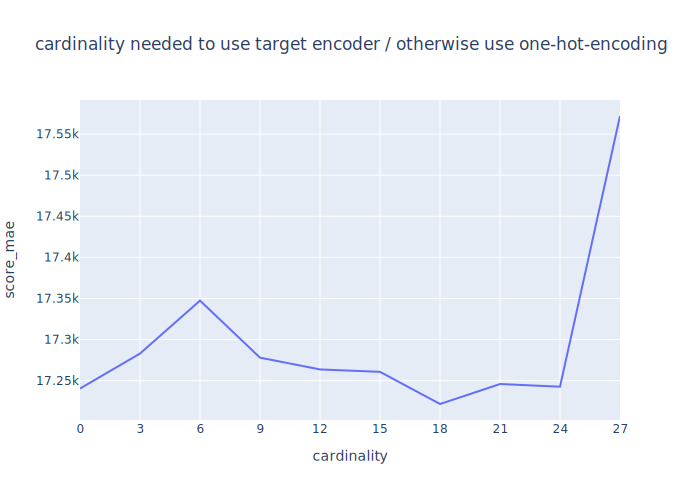

In [21]:
print(f"best cut in the cardinality to start using target encoders: {best_cardinality}, score_min_mae {best_score}")
fig = px.line(df_cardinality, x="cardinality", y="score_mae", title='cardinality needed to use target encoder / otherwise use one-hot-encoding')
fig.show()

Notice that 0 means we are just using target encoder. This approach seems to yield excelent results but not the best. The best result we get it when we use this approach only on the high cardinality value.

There are some caractheristic shown in this graph that are quite strange and not expected. It looks like when we use target encoder in all the categori]cal variables gives us better result than when we use one-hot-encoding in a subset of low cardinality. This can be a result of the simple imputer. Notice that the target encoder treats null or missing values as a new category and it give a value giving the relationship with y. So maybe it is not so strange. So maybe we should look for a way to choose between both imputer for each variable to se if we can improve further these results! 

In [16]:
len(X.Neighborhood.unique())

25

We just obtain the best MAE we have got so far! 
Notice the best MAE it just happened to be the one that uses TargetEncoder with columns with high cardinality.

In [27]:
numerical_col = [col for col in X.columns if str(X[col].dtypes)!='object' ]
numerical_col_imputed = [col for col in numerical_col if X[col].isnull().any()==True]
enc_target = [col for col in list(X.columns) if str(X[col].dtypes)=='object' and len(X[col].unique())>=18 ]

all_categories = [col for col in list(X.columns) if str(X[col].dtypes)=='object']
col_encoding = [col for col in all_categories if col not in enc_target ]

enc_target

['Neighborhood']

In [28]:
col_encoding

['MSZoning',
 'Street',
 'Alley',
 'LotShape',
 'LandContour',
 'Utilities',
 'LotConfig',
 'LandSlope',
 'Condition1',
 'Condition2',
 'BldgType',
 'HouseStyle',
 'RoofStyle',
 'RoofMatl',
 'Exterior1st',
 'Exterior2nd',
 'MasVnrType',
 'ExterQual',
 'ExterCond',
 'Foundation',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'Heating',
 'HeatingQC',
 'CentralAir',
 'Electrical',
 'KitchenQual',
 'Functional',
 'FireplaceQu',
 'GarageType',
 'GarageFinish',
 'GarageQual',
 'GarageCond',
 'PavedDrive',
 'PoolQC',
 'Fence',
 'MiscFeature',
 'SaleType',
 'SaleCondition']

Notice the best transform uses only one column as TargetEncoder who has more than 18 types of neighborhoods.